In [1]:
#https://github.com/jswhit/pyspharm/blob/master/examples/twolevel.py
%matplotlib notebook

import numpy as np
from spharm import Spharmt, getspecindx, gaussian_lats_wts
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import time

import numpy.random as npran
import matplotlib.animation as animation


In [2]:
# two-level baroclinic primitive equation model of
# Lee, S. and I. M. Held: 1993: Baroclinic Wave Packets in Models and Observations
# J. Atmos. Sci., 50, 1413-1428.
# http://dx.doi.org/10.1175/1520-0469(1993)050<1413:BWPIMA>2.0.CO;2

In [3]:
class TwoLevel(object):

    def __init__(self,sp,dt,ntrunc,ptop=0.,p0=1.e5,grav=9.80616,omega=7.292e-5,cp=1004,\
            rgas=287.,efold=3600.,ndiss=8,tdrag=1.e30,tdiab=1.e30,\
            umax=40,jetexp=2,delth=20,moistfact=1.0):
        # set model parameters
        self.p0 = p0 # mean surface pressure
        self.ptop = ptop # model top pressure
        self.rgas = rgas # gas constant for dry air
        self.grav = grav # gravity
        self.omega = omega # rotation rate
        self.cp = cp # specific heat of dry air at constant pressure
        self.delth = delth # static stability
        # factor to reduce static stability in rising air
        # (crude moist physics assuming air is saturated)
        # moistfact = 1 is dry model
        self.moistfact = moistfact
        dp = 0.5*(ptop-p0)
        exnf1 = cp*((p0+0.5*dp)/p0)**(rgas/cp)
        exnf2 = cp*((p0+1.5*dp)/p0)**(rgas/cp)
        self.delta_exnf = exnf2-exnf1 # diff in exner function between 2 levs.
        # efolding time scale for hyperdiffusion at shortest wavenumber
        self.efold = efold
        self.ndiss = ndiss # order of hyperdiffusion (2 for laplacian)
        self.sp = sp # Spharmt instance
        self.ntrunc = ntrunc # triangular truncation wavenumber
        self.dt = dt # time step (secs)
        self.tdiab = tdiab # lower layer drag timescale
        self.tdrag = tdrag # interface relaxation timescale
        # create lat/lon arrays
        delta = 2.*np.pi/sp.nlon
        if sp.gridtype == 'regular':
           lats1d = 0.5*np.pi-delta*np.arange(sp.nlat)
           wts = np.cos(lats1d)
        else:
           lats1d,wts = gaussian_lats_wts(sp.nlat)
           lats1d = lats1d*np.pi/180. # convert to radians.
        lons1d = np.arange(-np.pi,np.pi,delta)
        lons,lats = np.meshgrid(lons1d,lats1d)
        self.lons = lons; self.lats = lats
        # weights for computing global means.
        self.globalmeanwts = np.ones((sp.nlat,sp.nlon))*wts[:,np.newaxis]
        self.globalmeanwts = self.globalmeanwts/self.globalmeanwts.sum()
        self.f = 2.*omega*np.sin(lats)[:,:,np.newaxis] # coriolis
        # create laplacian operator and its inverse.
        indxm, indxn = getspecindx(ntrunc)
        indxn = indxn.astype(np.float32)
        totwavenum = indxn*(indxn+1.0)
        self.lap = -totwavenum/sp.rsphere**2
        self.ilap = np.zeros(self.lap.shape, np.float32)
        self.ilap[1:] = 1./self.lap[1:]
        # hyperdiffusion operator
        self.hyperdiff = -(1./efold)*(totwavenum/totwavenum[-1])**(ndiss/2)
        # set equilibrium layer thicknes profile.
        self._interface_profile(umax,jetexp)

    def _interface_profile(self,umax,jetexp):
        ug = np.zeros((self.sp.nlat,self.sp.nlon,2),np.float32)
        vg = np.zeros((self.sp.nlat,self.sp.nlon,2),np.float32)
        ug[:,:,1] = umax*np.sin(2.*self.lats)**jetexp
        vrtspec, divspec = self.sp.getvrtdivspec(ug,vg,self.ntrunc)
        thetaspec = self.nlbalance(vrtspec)
        self.thetaref = self.sp.spectogrd(thetaspec)
        self.uref = ug

    def nlbalance(self,vrtspec):
        # solve nonlinear balance eqn to get potential temp given vorticity.
        vrtg = self.sp.spectogrd(vrtspec)
        divspec2 = np.zeros(vrtspec.shape, vrtspec.dtype)
        ug,vg = self.sp.getuv(vrtspec,divspec2)
        # horizontal vorticity flux
        tmpg1 = ug*(vrtg+self.f); tmpg2 = vg*(vrtg+self.f)
        # compute vort flux contributions to vorticity and divergence tend.
        tmpspec, dvrtdtspec = self.sp.getvrtdivspec(tmpg1,tmpg2,self.ntrunc)
        ddivdtspec = tmpspec[:,1]-tmpspec[:,0]
        ke = 0.5*(ug**2+vg**2)
        tmpspec = self.sp.grdtospec(ke[:,:,1]-ke[:,:,0],self.ntrunc)
        return (tmpspec - self.ilap*ddivdtspec)/self.delta_exnf

    def gettend(self,vrtspec,divspec,thetaspec):
        # compute tendencies.
        # first, transform fields from spectral space to grid space.
        vrtg = self.sp.spectogrd(vrtspec)
        # this is baroclinic div = divupper-divlower
        # omega = dp*divg/2
        # baroptropic div is zero.
        divg = self.sp.spectogrd(divspec)
        divspec2 = np.empty(vrtspec.shape, vrtspec.dtype)
        divspec2[:,0] = -0.5*divspec
        divspec2[:,1] = 0.5*divspec
        ug,vg = self.sp.getuv(vrtspec,divspec2)
        thetag = self.sp.spectogrd(thetaspec)
        self.u = ug; self.v = vg; self.divg = divg
        self.vrt = vrtg; self.theta = thetag
        vadvu = 0.25*(divg*(ug[:,:,1]-ug[:,:,0]))
        vadvv = 0.25*(divg*(vg[:,:,1]-vg[:,:,0]))
        # horizontal vorticity flux
        tmpg1 = ug*(vrtg+self.f); tmpg2 = vg*(vrtg+self.f)
        # add lower layer drag and vertical advection contributions
        tmpg1[:,:,0] += vadvv + vg[:,:,0]/self.tdrag
        tmpg2[:,:,0] += -vadvu - ug[:,:,0]/self.tdrag
        tmpg1[:,:,1] += vadvv
        tmpg2[:,:,1] += -vadvu
        # compute vort flux contributions to vorticity and divergence tend.
        tmpspec, dvrtdtspec = self.sp.getvrtdivspec(tmpg1,tmpg2,self.ntrunc)
        ddivdtspec = tmpspec[:,1]-tmpspec[:,0]
        dvrtdtspec *= -1
        # vorticity hyperdiffusion
        dvrtdtspec += self.hyperdiff[:,np.newaxis]*vrtspec
        # add laplacian term and hyperdiffusion to div tend.
        ke = 0.5*(ug**2+vg**2)
        tmpspec = self.sp.grdtospec(ke[:,:,1]-ke[:,:,0],self.ntrunc)
        ddivdtspec += self.hyperdiff*divspec - \
                      self.lap*(tmpspec - self.delta_exnf*thetaspec)
        # horizontal gradient of pot. temp.
        thetagradx, thetagrady = self.sp.getgrad(thetaspec)
        # tendency of pot. temp.
        vadvtheta = 0.5*divg*self.delth
        # in rising air, use reduced static stability
        if self.moistfact < 1:
            wmean = ((divg + np.abs(divg))*self.globalmeanwts).sum()
            # need to remove global mean vertical velocity or
            # global mean temp will increase.
            self.heat = 0.25*(divg + np.abs(divg) - wmean)*self.delth*(1.-self.moistfact)
        else: # moistfact=1 is dry model
            self.heat = np.zeros(self.theta.shape, self.theta.dtype)
        umean = 0.5*(ug[:,:,1]+ug[:,:,0])
        vmean = 0.5*(vg[:,:,1]+vg[:,:,0])
        # advection
        tmpg = -umean*thetagradx - vmean*thetagrady - vadvtheta
        # thermal relaxation term.
        tmpg += (self.thetaref-thetag)/self.tdiab
        # heating term.
        tmpg += self.heat
        dthetadtspec = self.sp.grdtospec(tmpg, self.ntrunc)
        # hyperdiffusion
        dthetadtspec += self.hyperdiff*thetaspec
        return dvrtdtspec,ddivdtspec,dthetadtspec

    def rk4step(self,vrtspec,divspec,thetaspec):
        # update state using 4th order runge-kutta
        dt = self.dt
        k1vrt,k1div,k1thk = \
        self.gettend(vrtspec,divspec,thetaspec)
        k2vrt,k2div,k2thk = \
        self.gettend(vrtspec+0.5*dt*k1vrt,divspec+0.5*dt*k1div,thetaspec+0.5*dt*k1thk)
        k3vrt,k3div,k3thk = \
        self.gettend(vrtspec+0.5*dt*k2vrt,divspec+0.5*dt*k2div,thetaspec+0.5*dt*k2thk)
        k4vrt,k4div,k4thk = \
        self.gettend(vrtspec+dt*k3vrt,divspec+dt*k3div,thetaspec+dt*k3thk)
        vrtspec += dt*(k1vrt+2.*k2vrt+2.*k3vrt+k4vrt)/6.
        divspec += dt*(k1div+2.*k2div+2.*k3div+k4div)/6.
        thetaspec += dt*(k1thk+2.*k2thk+2.*k3thk+k4thk)/6.
        return vrtspec,divspec,thetaspec

In [4]:
    # grid, time step info
    nlons = 128  # number of longitudes
    ntrunc = 42 # spectral truncation (for alias-free computations)
    nlats = int(nlons/2)+1 # for regular grid.
    gridtype = 'regular'
    #nlats = nlons/2 # for gaussian grid.
    #gridtype = 'gaussian'
    dt = 1800 # time step in seconds
    itmax = int(5*(86400/dt)) # integration length in days
    umax = 50. # jet speed
    jetexp = 6 # parameter controlling jet width

In [5]:
    # create spherical harmonic instance.
    rsphere = 6.37122e6 # earth radius
    sp = Spharmt(nlons,nlats,rsphere=rsphere,gridtype=gridtype)

In [6]:
    # create model instance using default parameters.
    model = TwoLevel(sp,dt,ntrunc)

In [7]:
    # vort, div initial conditions
    psipert = np.zeros((sp.nlat,sp.nlon,2),np.float32)
    psipert[:,:,1] = 5.e6*np.sin((model.lons-np.pi))**12*np.sin(2.*model.lats)**12
    psipert = np.where(model.lons[:,:,np.newaxis] > 0., 0, psipert)
    ug = np.zeros((sp.nlat,sp.nlon,2),np.float32)
    vg = np.zeros((sp.nlat,sp.nlon,2),np.float32)
    ug[:,:,1] = umax*np.sin(2.*model.lats)**jetexp
    vrtspec, tmpspec = sp.getvrtdivspec(ug,vg,model.ntrunc)
    vrtspec = vrtspec + model.lap[:,np.newaxis]*sp.grdtospec(psipert,model.ntrunc)
    thetaspec = model.nlbalance(vrtspec)
    divspec = np.zeros(thetaspec.shape, thetaspec.dtype)

In [8]:
    # time loop.
    for ncycle in range(itmax+1):
        t = ncycle*model.dt
        vrtspec, divspec, thetaspec = model.rk4step(vrtspec, divspec, thetaspec)
        print('t=%6.2f hours: v min/max %6.2f, %6.2f theta min/max %6.2f, %6.2f'%\
        (t/3600.,model.v.min(), model.v.max(), model.theta.min(),
            model.theta.max()))


t=  0.00 hours: v min/max  -2.42,   2.34 theta min/max -49.81,  17.59
t=  0.50 hours: v min/max  -2.44,   2.28 theta min/max -49.81,  17.59
t=  1.00 hours: v min/max  -2.48,   2.25 theta min/max -49.81,  17.59
t=  1.50 hours: v min/max  -2.53,   2.22 theta min/max -49.81,  17.59
t=  2.00 hours: v min/max  -2.57,   2.19 theta min/max -49.81,  17.59
t=  2.50 hours: v min/max  -2.60,   2.16 theta min/max -49.81,  17.59
t=  3.00 hours: v min/max  -2.62,   2.14 theta min/max -49.81,  17.59
t=  3.50 hours: v min/max  -2.64,   2.12 theta min/max -49.81,  17.59
t=  4.00 hours: v min/max  -2.68,   2.12 theta min/max -49.81,  17.59
t=  4.50 hours: v min/max  -2.71,   2.12 theta min/max -49.81,  17.59
t=  5.00 hours: v min/max  -2.74,   2.12 theta min/max -49.81,  17.59
t=  5.50 hours: v min/max  -2.77,   2.12 theta min/max -49.81,  17.59
t=  6.00 hours: v min/max  -2.80,   2.12 theta min/max -49.81,  17.59
t=  6.50 hours: v min/max  -2.83,   2.11 theta min/max -49.81,  17.59
t=  7.00 hours: v mi

t= 59.50 hours: v min/max -22.38,  19.23 theta min/max -49.81,  17.60
t= 60.00 hours: v min/max -23.00,  19.64 theta min/max -49.81,  17.59
t= 60.50 hours: v min/max -23.59,  20.19 theta min/max -49.81,  17.60
t= 61.00 hours: v min/max -24.15,  20.72 theta min/max -49.81,  17.60
t= 61.50 hours: v min/max -24.68,  21.24 theta min/max -49.81,  17.60
t= 62.00 hours: v min/max -25.18,  21.74 theta min/max -49.81,  17.60
t= 62.50 hours: v min/max -25.64,  22.22 theta min/max -49.81,  17.60
t= 63.00 hours: v min/max -26.17,  22.72 theta min/max -49.81,  17.60
t= 63.50 hours: v min/max -26.92,  23.33 theta min/max -49.81,  17.60
t= 64.00 hours: v min/max -27.65,  23.91 theta min/max -49.81,  17.59
t= 64.50 hours: v min/max -28.34,  24.45 theta min/max -49.81,  17.59
t= 65.00 hours: v min/max -29.00,  24.96 theta min/max -49.81,  17.59
t= 65.50 hours: v min/max -29.62,  25.60 theta min/max -49.81,  17.59
t= 66.00 hours: v min/max -30.20,  26.44 theta min/max -49.81,  17.59
t= 66.50 hours: v mi

t=119.00 hours: v min/max -106.77, 112.52 theta min/max -49.81,  17.59
t=119.50 hours: v min/max -108.58, 112.91 theta min/max -49.81,  17.59
t=120.00 hours: v min/max -110.56, 113.26 theta min/max -49.80,  17.59


In [9]:
lons1d = model.lons[0,:]*180./np.pi
lats1d = model.lats[:,0]*180./np.pi

<IPython.core.display.Javascript object>


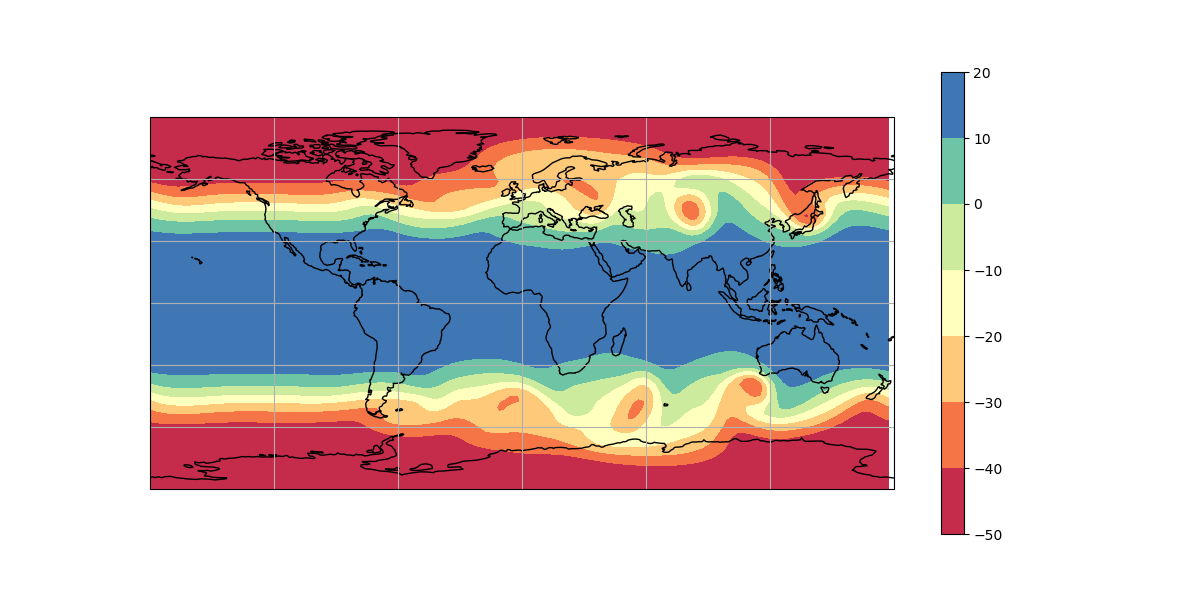

<IPython.core.display.Javascript object>


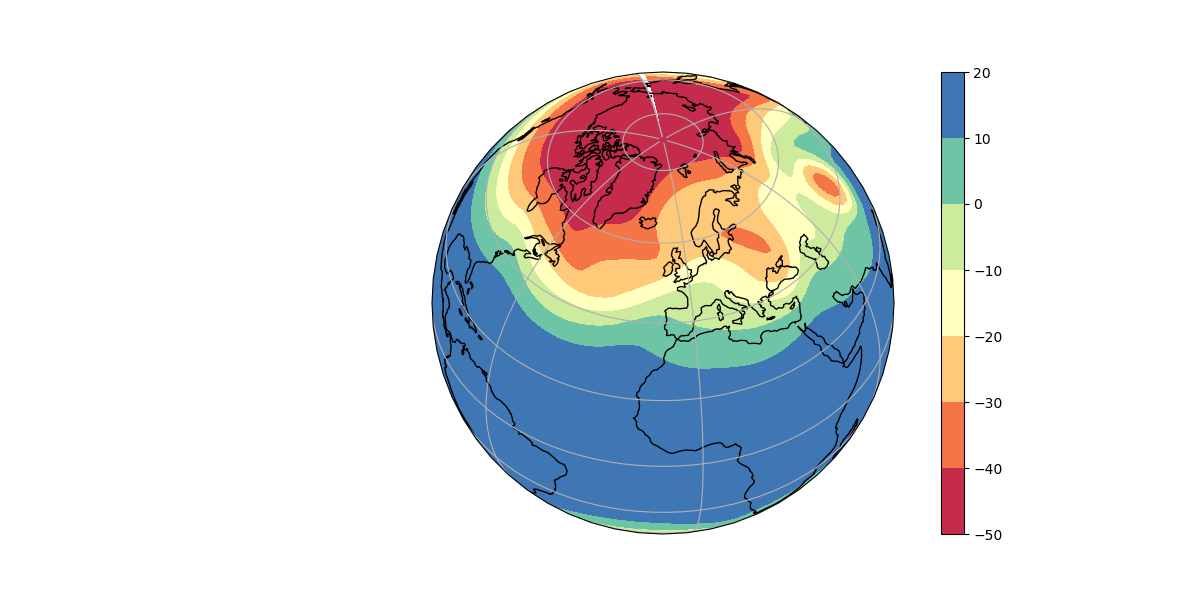

/home/ec2-user/miniconda3/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/ec2-user/miniconda3/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/ec2-user/miniconda3/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/ec2-user/miniconda3/lib/python3.9/site-packages/cartopy/cr

In [10]:


plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
ax.gridlines()
#im=plt.contourf(lons1d*180/np.pi, lats1d*180.0/np.pi, pvg, transform=ccrs.PlateCarree(), cmap=plt.cm.Spectral)
im=plt.contourf(lons1d, lats1d, model.theta, transform=ccrs.PlateCarree(), cmap=plt.cm.Spectral)
#im=plt.contourf(lons1d*180/np.pi, lats1d*180.0/np.pi, vrtg, transform=ccrs.PlateCarree(), cmap=plt.cm.Spectral)
plt.colorbar(im)
plt.show()




plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.Orthographic(-10, 45))

#ax.add_feature(cfeature.OCEAN, zorder=0)
#ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax.coastlines()
ax.set_global()
ax.gridlines()

#ax.contourf(np.rad2deg(lons1d), np.rad2deg(lats1d), pvg, transform=ccrs.PlateCarree(), cmap='nipy_spectral')
im=ax.contourf(lons1d, lats1d, model.theta, transform=ccrs.PlateCarree(), cmap=plt.cm.Spectral)
plt.colorbar(im)
plt.show()

In [11]:
# set model parameters.
nlons = 128  # number of longitudes
ntrunc = 42  # spectral truncation (for alias-free computations)
nlats = int(nlons/2)+1 # for regular grid.
gridtype = 'regular'
dt = 900 # time step in seconds
tdiab = 12.*86400 # thermal relaxation time scale
tdrag = 4.*86400. # lower layer drag
efold = 4*dt # hyperdiffusion time scale
rsphere = 6.37122e6 # earth radius
jetexp = 2
umax = 40
moistfact = 0.1

In [12]:
# create spherical harmonic instance.
sp = Spharmt(nlons,nlats,rsphere=rsphere,gridtype=gridtype)

# create model instance.
model =\
TwoLevel(sp,dt,ntrunc,efold=efold,tdiab=tdiab,tdrag=tdrag,jetexp=jetexp,umax=umax,moistfact=moistfact)

In [13]:
# initial state is equilbrium jet + random noise.
vg = np.zeros((sp.nlat,sp.nlon,2),np.float32)
ug = model.uref
vrtspec, divspec = sp.getvrtdivspec(ug,vg,model.ntrunc)
psispec = np.zeros(vrtspec.shape, vrtspec.dtype)
psispec.real += npran.normal(scale=1.e4,size=(psispec.shape))
psispec.imag += npran.normal(scale=1.e4,size=(psispec.shape))
vrtspec = vrtspec + model.lap[:,np.newaxis]*psispec
thetaspec = model.nlbalance(vrtspec)
divspec = np.zeros(thetaspec.shape, thetaspec.dtype)
model.vrt = sp.spectogrd(vrtspec)
model.theta = sp.spectogrd(thetaspec)
model.heat = np.zeros(model.theta.shape, model.theta.dtype)

<IPython.core.display.Javascript object>


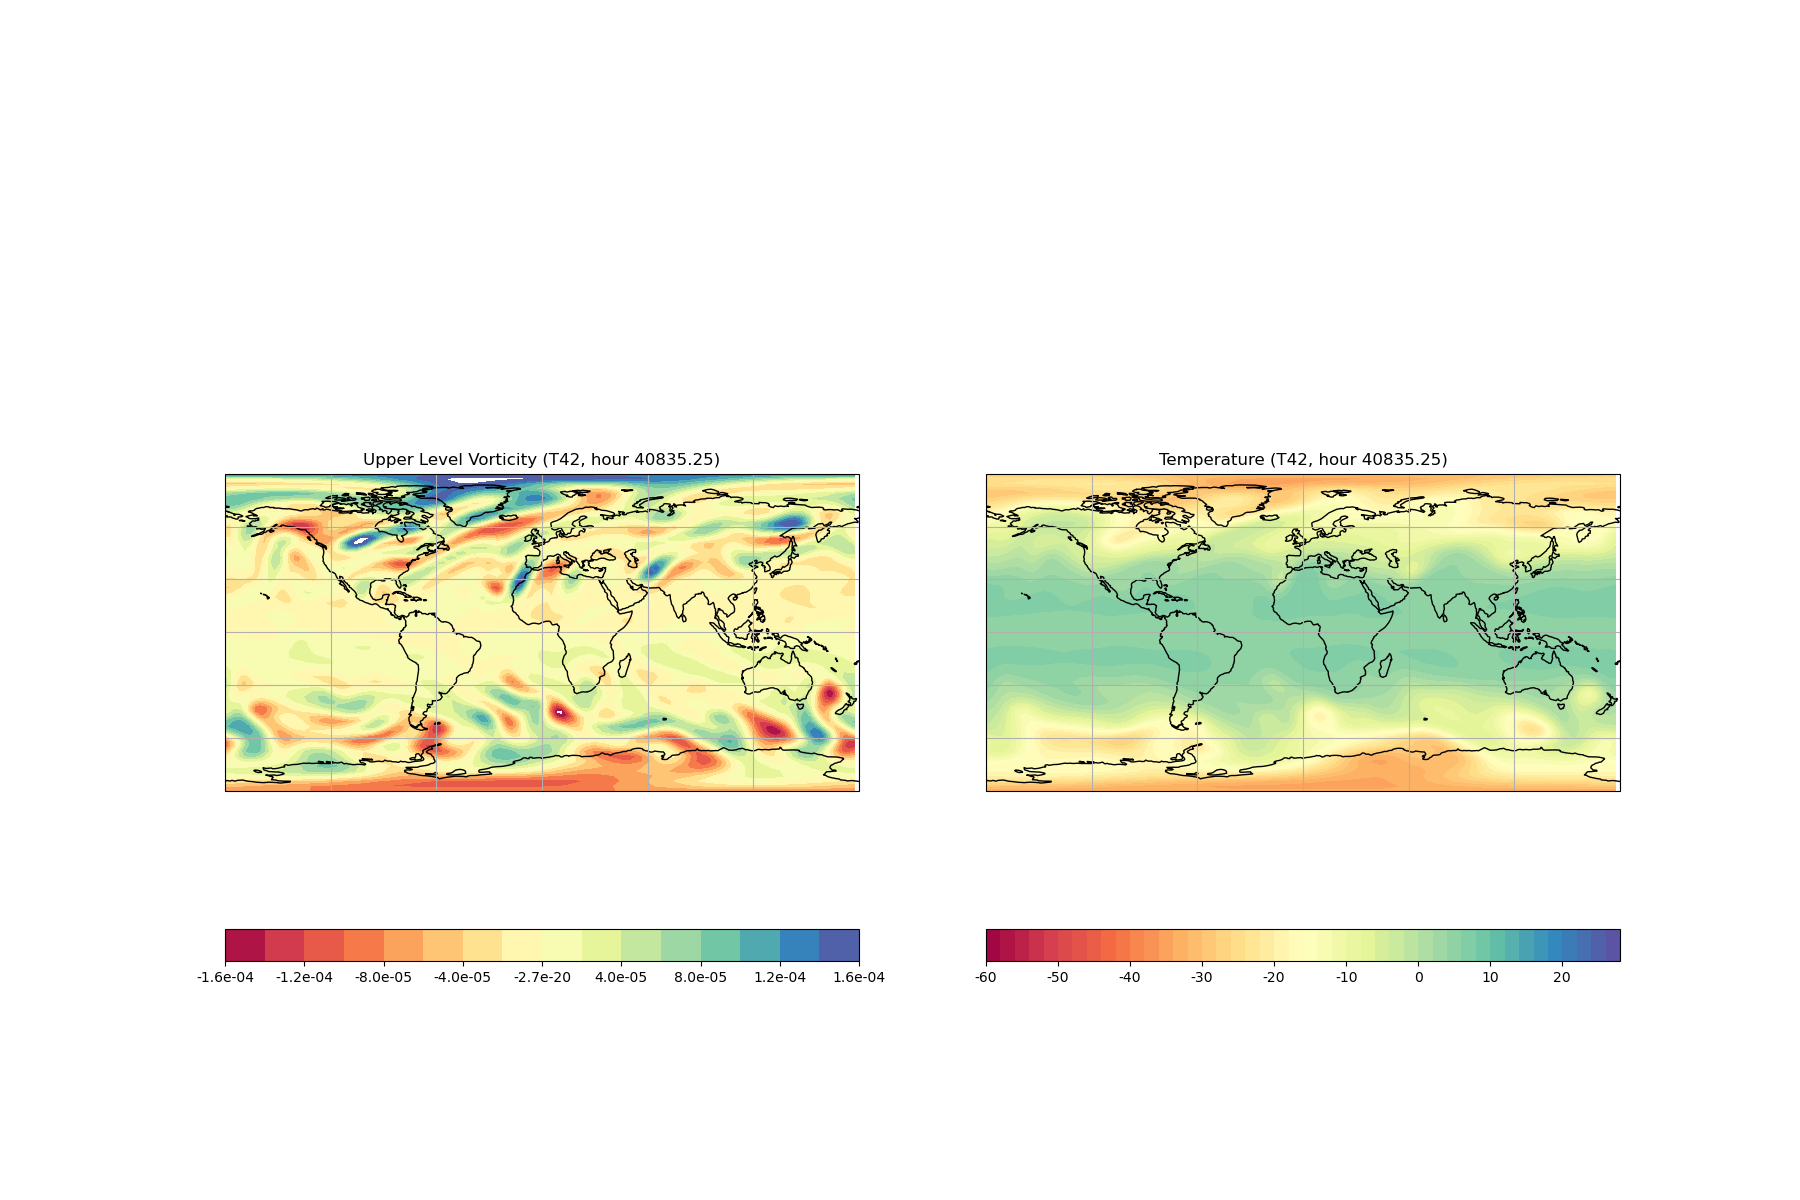

In [14]:
# animate vorticity from solution as it is running
# first, create initial frame
#plt.figure(figsize=(12,6))
#ax = plt.axes(projection=ccrs.PlateCarree())
#fig = plt.figure(figsize=(8,10))
#ax1 = fig.add_subplot(2,1,1)
#ax2 = fig.add_subplot(2,1,2)

#m = Basemap(projection='kav7',lon_0=0)

fig, axs = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(18,12)) 
ax1 = axs[0]
ax2 = axs[1]

for a in axs:
    a.coastlines()
    a.set_global()
    a.gridlines()

lons1d = model.lons[0,:]*180./np.pi
lats1d = model.lats[:,0]*180./np.pi

#data1,lons1dx = addcyclic(model.vrt[:,:,1],lons1d)
#data2,lons1dx = addcyclic(model.theta,lons1d)
data1 = model.vrt[:,:,1]
data2 = model.theta

levs1 = np.arange(-1.6e-4,1.61e-4,2.e-5)
levs2 = np.arange(-60,30,2)

CS1=ax1.contourf(lons1d,lats1d,data1,levs1,transform=ccrs.PlateCarree(), cmap=plt.cm.Spectral)
CS2=ax2.contourf(lons1d,lats1d,data2,levs2,transform=ccrs.PlateCarree(), cmap=plt.cm.Spectral)
cb1 = plt.colorbar(CS1,location='bottom',format='%3.1e',ax=ax1)
cb2 = plt.colorbar(CS2,location='bottom',format='%g', ax=ax2)
t = 0.
txt1 = ax1.set_title('Upper Level Vorticity (T%s, hour %6.2f)' % (ntrunc,t/3600.))
txt2 = ax2.set_title('Temperature (T%s, hour %6.2f)' % (ntrunc,t/3600.))


# run model, update contours and title on the fly.
def updatefig(*args):
    global vrtspec,divspec,thetaspec,CS1,CS2,txt1,txt2,t
    
    t += model.dt
    vrtspec, divspec, thetaspec = model.rk4step(vrtspec, divspec, thetaspec)
    data1 = model.vrt[:,:,1]
    data2 = model.theta
    
    # remove old contours, add new ones.
    
    for c in CS1.collections: c.remove()
    CS1=ax1.contourf(lons1d,lats1d,data1,levs1,transform=ccrs.PlateCarree(), cmap=plt.cm.Spectral)
    
    for c in CS2.collections: c.remove()
    CS2=ax2.contourf(lons1d,lats1d,data2,levs2,transform=ccrs.PlateCarree(), cmap=plt.cm.Spectral)
    
    # update titles.
    txt1.set_text('Upper Level Vorticity (T%s, hour %6.2f)' % (ntrunc,t/3600.))
    txt2.set_text('Temperature (T%s, hour %6.2f)' % (ntrunc,t/3600.))
    
ani = animation.FuncAnimation(fig, updatefig)
plt.show()
